Start Complete Streamflow-Precipitation Elasticity Analysis (XGBoost)
Data Loading and Preprocessing
Original data shape: (4346, 198)
Shape after filtering: (4042, 198)
Training set: (3233, 196), Test set: (809, 196)

Target Variable Distribution Analysis


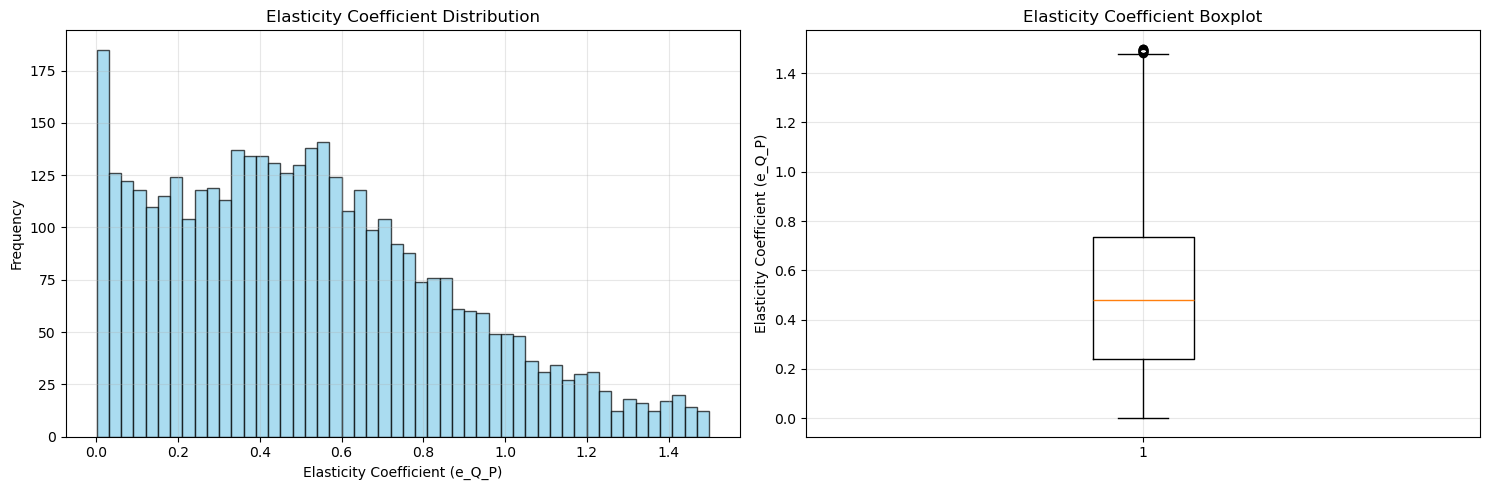

 Descriptive Statistics:
   Mean: 0.517
   Median: 0.481
   Std Dev: 0.344
   Min: 0.000
   Max: 1.499
   Skewness: 0.562

Initial Feature Selection (XGBoost)
Top 30 important features selected:
    1. swc_pc_s06          : 0.3551
    2. cmi_ix_syr          : 0.0628
    3. run_mm_syr          : 0.0531
    4. swc_pc_s05          : 0.0283
    5. swc_pc_s07          : 0.0203
    6. wet_pc_s05          : 0.0174
    7. slp_dg_sav          : 0.0168
    8. tbi_cl_smj          : 0.0153
    9. pnv_pc_s15          : 0.0139
   10. fec_cl_smj          : 0.0108
   ... and 20 other features


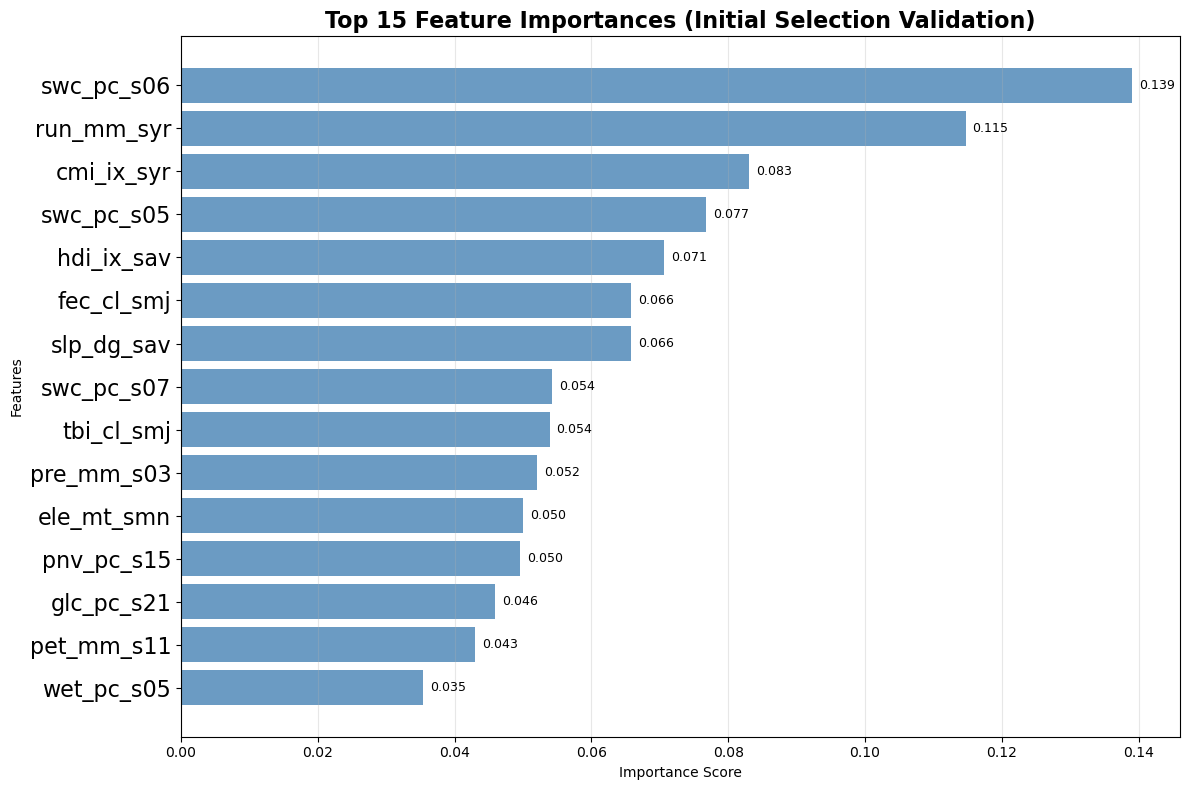


 XGBoost Hyperparameter Optimization and Feature Selection

 Testing 10 features...
   CV R²: 0.5663
   Training R²: 0.8185
   Test R²: 0.6036
   Overfitting: 0.2149

 Testing 15 features...
   CV R²: 0.5887
   Training R²: 0.9118
   Test R²: 0.6249
   Overfitting: 0.2869

 Testing 20 features...
   CV R²: 0.5931
   Training R²: 0.8583
   Test R²: 0.6269
   Overfitting: 0.2314

 Testing 25 features...
   CV R²: 0.5947
   Training R²: 0.8729
   Test R²: 0.6239
   Overfitting: 0.2490

 Performance Comparison Across Different Feature Numbers:
   n_features   cv_r2  test_r2  overfitting
0          10  0.5663   0.6036       0.2149
1          15  0.5887   0.6249       0.2869
2          20  0.5931   0.6269       0.2314
3          25  0.5947   0.6239       0.2490

 Best Configuration:
   Number of features: 20
   Test R²: 0.6269
   Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'subsample': 0.8}


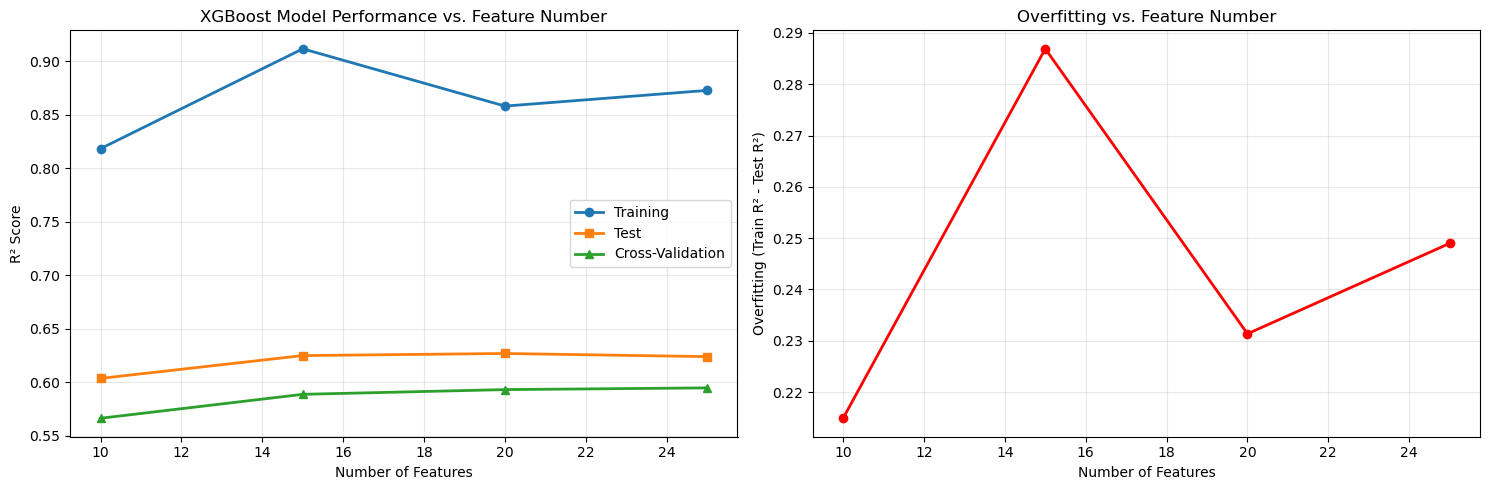


 Final XGBoost Model Evaluation
 XGBoost Model Performance Metrics:

Training:
   R²: 0.8583
   RMSE: 0.1297
   MAE: 0.0948

Test:
   R²: 0.6269
   RMSE: 0.2097
   MAE: 0.1496

10-fold Cross-Validation:
   Mean R²: 0.5924 ± 0.0437
   R² Range: [0.5339, 0.6510]


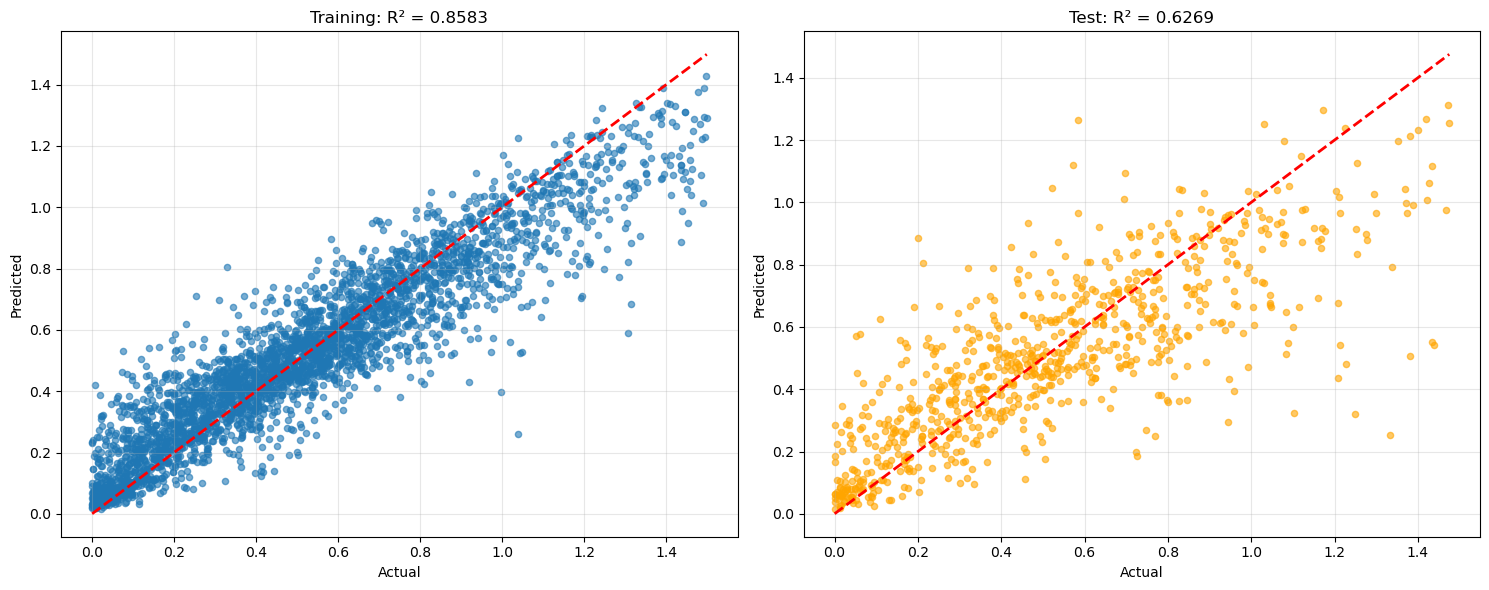


 In-depth XGBoost Feature Importance Analysis
 Top 10 most important features (XGBoost):
    1. swc_pc_s06               : 0.1799
    3. run_mm_syr               : 0.1110
    2. cmi_ix_syr               : 0.0786
    4. swc_pc_s05               : 0.0740
    7. slp_dg_sav               : 0.0493
    6. wet_pc_s05               : 0.0447
   13. hdi_ix_sav               : 0.0445
   19. gdp_ud_sav               : 0.0392
    8. tbi_cl_smj               : 0.0387
   11. ele_mt_smn               : 0.0366


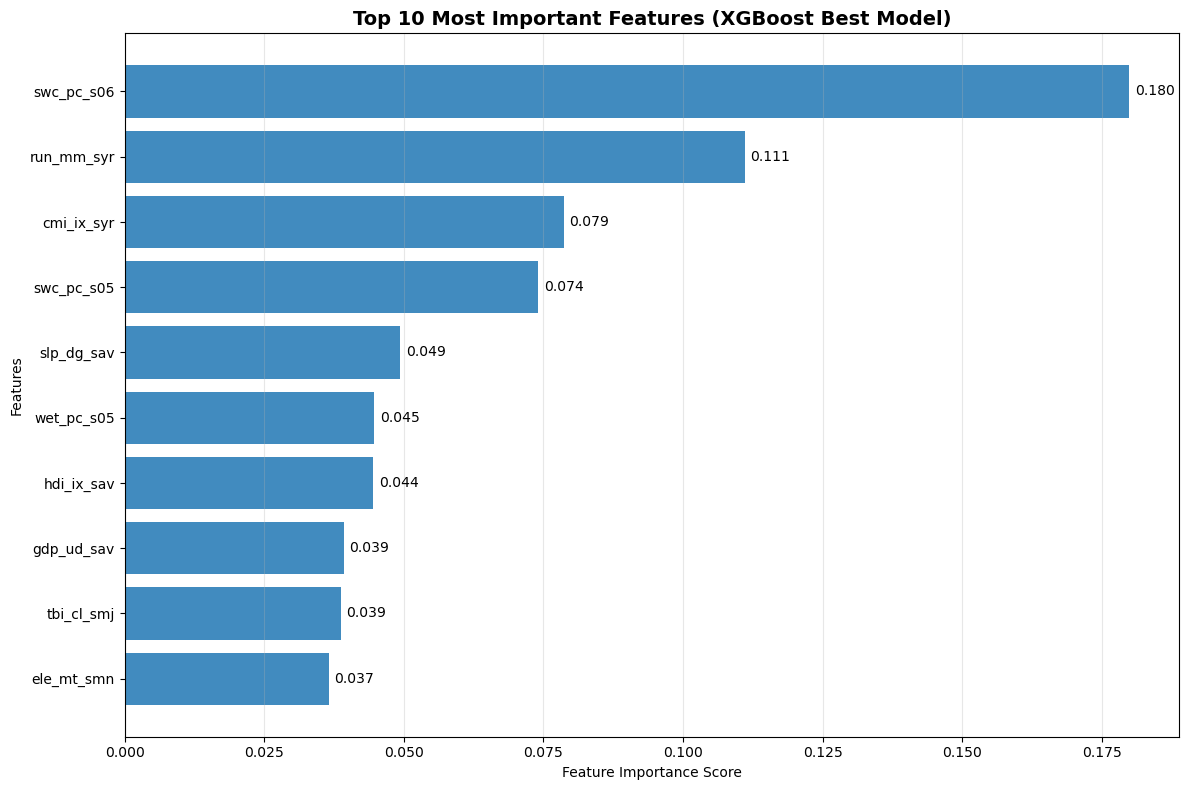


 Physical Process Interpretation (Regex-based, leakage-safe)
Coverage audit (on FINAL selected features):
   Total selected features: 20
   Used after exclude_hydrology=True: 19
   Classified into known families: 17  (89.5%)
   Unclassified (need rule/check): 2
   → Unclassified examples (top 2): ['tbi_cl_smj', 'fec_cl_smj']
 Note: *_cl_smj fields are categorical codes. For linear models use one-hot; XGBoost can ingest integers but interpretation cleaner with one-hot.

Importance by physical process (cumulative, XGBoost):
   • Soil_Water     : 0.3113
   • Climate        : 0.1629
   • Land_Cover     : 0.1143
   • Topography     : 0.0859
   • Human_Impact   : 0.0837
   • Unclassified   : 0.0703
   • Precipitation  : 0.0606


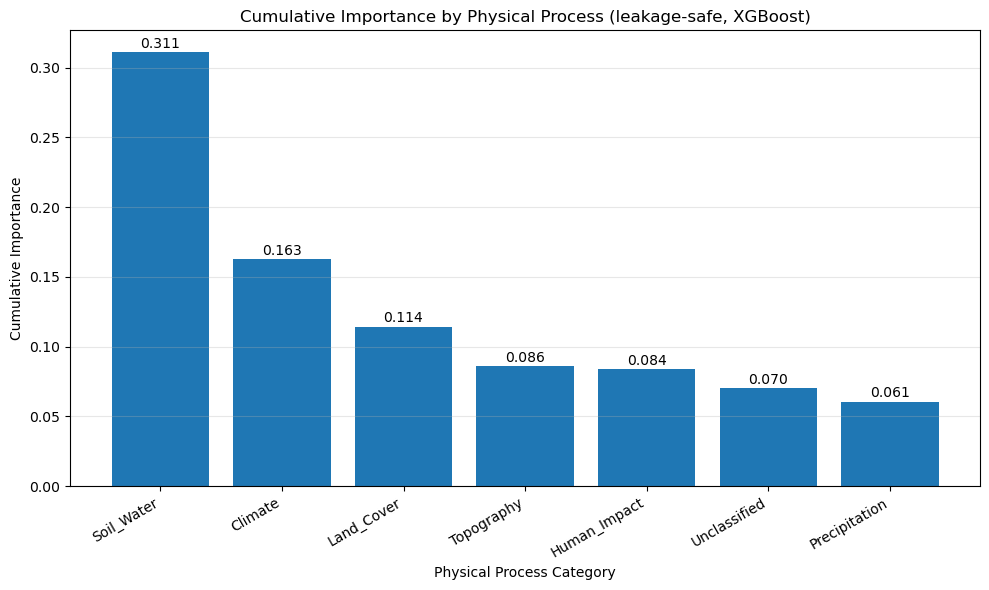


Top features by |importance| (after leakage-safe filtering):
   - swc_pc_s06  →  Soil_Water  (0.1799)
   - cmi_ix_syr  →  Climate  (0.0786)
   - swc_pc_s05  →  Soil_Water  (0.0740)
   - slp_dg_sav  →  Topography  (0.0493)
   - wet_pc_s05  →  Land_Cover  (0.0447)
   - hdi_ix_sav  →  Human_Impact  (0.0445)
   - gdp_ud_sav  →  Human_Impact  (0.0392)
   - tbi_cl_smj  →  Unclassified  (0.0387)
   - ele_mt_smn  →  Topography  (0.0366)
   - glc_pc_s21  →  Land_Cover  (0.0353)


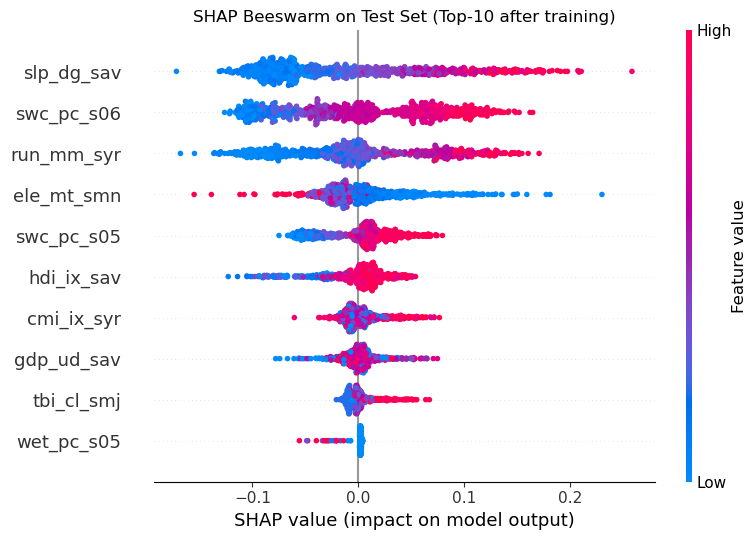

[Info] Spearman rho (XGB gain vs SHAP |mean| on Top-10): 0.467

 XGBoost Analysis Completed Successfully!

 XGBoost Analysis Summary:
   Optimal number of features: 20
   Test set R²: 0.6269
   Most important physical processes: ['Soil_Water', 'Climate', 'Topography', 'Land_Cover', 'Human_Impact', 'Unclassified']
   Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'subsample': 0.8}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
import re
import shap
warnings.filterwarnings('ignore')


class StreamflowElasticityAnalysis:
    def __init__(self, data_path):
        """
        Initialize Streamflow-Precipitation Elasticity Analysis class with XGBoost
        """
        self.data_path = data_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.best_model = None
        self.selected_features = None   
        self.final_features = None      
        self.best_n_features = None
        self.best_params = None

    def load_and_preprocess_data(self, low_threshold=0, upper_threshold=1.5):
        """
        Load and preprocess data
        """
        print("=" * 60)
        print("Data Loading and Preprocessing")
        print("=" * 60)

        self.data = pd.read_csv(self.data_path)
        print(f"Original data shape: {self.data.shape}")

        # Clip/Filter target
        mask = (self.data.iloc[:, 1] >= low_threshold) & (self.data.iloc[:, 1] <= upper_threshold)
        self.data = self.data[mask]
        print(f"Shape after filtering: {self.data.shape}")

        # y and X
        self.y = self.data.iloc[:, 1]      # e_Q_P
        self.X = self.data.iloc[:, 2:]     # features

        # Drop columns with any NaNs
        missing_cols = self.X.isnull().sum()
        if missing_cols.sum() > 0:
            print(f"Missing values found: {missing_cols[missing_cols > 0].sum()}")
            self.X = self.X.dropna(axis=1)
            print(f"Number of features after removing missing values: {self.X.shape[1]}")

        # Stratified split by y quantiles
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42,
            stratify=pd.qcut(self.y, q=5, duplicates='drop')
        )
        print(f"Training set: {self.X_train.shape}, Test set: {self.X_test.shape}")

    def explore_target_distribution(self):
        """
        Explore target variable distribution
        """
        print("\n" + "=" * 60)
        print("Target Variable Distribution Analysis")
        print("=" * 60)

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].hist(self.y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0].set_title('Elasticity Coefficient Distribution')
        axes[0].set_xlabel('Elasticity Coefficient (e_Q_P)')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True, alpha=0.3)

        axes[1].boxplot(self.y)
        axes[1].set_title('Elasticity Coefficient Boxplot')
        axes[1].set_ylabel('Elasticity Coefficient (e_Q_P)')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f" Descriptive Statistics:")
        print(f"   Mean: {self.y.mean():.3f}")
        print(f"   Median: {self.y.median():.3f}")
        print(f"   Std Dev: {self.y.std():.3f}")
        print(f"   Min: {self.y.min():.3f}")
        print(f"   Max: {self.y.max():.3f}")
        print(f"   Skewness: {self.y.skew():.3f}")

    def initial_feature_selection(self, n_features=30):
        """
        Initial feature selection using XGBoost: rank features by gain/weight (default importance)
        and keep top n_features as candidate pool.
        """
        print("\n" + "=" * 60)
        print("Initial Feature Selection (XGBoost)")
        print("=" * 60)

        xgb_initial = XGBRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )
        xgb_initial.fit(self.X_train, self.y_train)

        importances = xgb_initial.feature_importances_
        indices = np.argsort(importances)[::-1][:n_features]
        self.selected_features = list(self.X.columns[indices])

        print(f"Top {n_features} important features selected:")
        for i, feature in enumerate(self.selected_features[:10]):
            print(f"   {i+1:2d}. {feature:20s}: {importances[indices[i]]:.4f}")
        if n_features > 10:
            print(f"   ... and {n_features-10} other features")

        return self.selected_features

    def plot_feature_importance(self, top_n=15):
        if self.selected_features is None:
            print(" Please run initial feature selection first.")
            return

    
        # Use a temporary XGBoost model with simple parameters for validation
        xgb_temp = XGBRegressor(
            n_estimators=200,  # Simple configuration for quick validation
            random_state=42,
            verbosity=0,
            n_jobs=-1
        )
    
        # Select top_n features from the initially selected features
        features_to_plot = self.selected_features[:min(top_n, len(self.selected_features))]
        X_selected = self.X_train[features_to_plot]
    
        # Fit the temporary model
        xgb_temp.fit(X_selected, self.y_train)
    
        # Get feature importances
        importances = xgb_temp.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12, 8))
        plt.title(f'Top {len(features_to_plot)} Feature Importances (Initial Selection Validation)', 
                fontsize=16, fontweight='bold')
    
        # Create horizontal bar chart
        bars = plt.barh(range(len(features_to_plot)), importances[indices], 
                    color='steelblue', alpha=0.8)
    
        # Set y-axis labels (feature names)
        plt.yticks(range(len(features_to_plot)), 
                [features_to_plot[i] for i in indices], fontsize=16)
    
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.gca().invert_yaxis()  # Highest importance at top
    
        # Add value labels on bars
        for i, v in enumerate(importances[indices]):
            plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)
    
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    

    def optimize_hyperparameters(self, n_features_list=[10, 15, 20, 25]):
        """
        Hyperparameter optimization and feature number selection for XGBoost.
        Chooses best k (from selected_features) and the best hyperparameters jointly.
        """
        print("\n" + "=" * 60)
        print(" XGBoost Hyperparameter Optimization and Feature Selection")
        print("=" * 60)

        best_score = -np.inf
        best_params = {}
        best_n_features = 0
        best_final_features = None
        results = []

        param_grid = {
            'n_estimators': [200, 300, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'reg_alpha': [0, 0.1],   # L1
            'reg_lambda': [1, 1.5]   # L2
        }

        for n_feat in n_features_list:
            print(f"\n Testing {n_feat} features...")
            current_feats = self.selected_features[:min(n_feat, len(self.selected_features))]
            X_train_sel = self.X_train[current_feats]
            X_test_sel = self.X_test[current_feats]

            xgb_model = XGBRegressor(random_state=42, verbosity=0, n_jobs=-1)
            grid_search = GridSearchCV(
                xgb_model, param_grid, cv=5,
                scoring='r2', n_jobs=-1, verbose=0
            )
            grid_search.fit(X_train_sel, self.y_train)

            train_score = grid_search.score(X_train_sel, self.y_train)
            test_score = grid_search.score(X_test_sel, self.y_test)
            cv_score = grid_search.best_score_

            results.append({
                'n_features': len(current_feats),
                'train_r2': train_score,
                'test_r2': test_score,
                'cv_r2': cv_score,
                'overfitting': train_score - test_score,
                'best_params': grid_search.best_params_
            })

            print(f"   CV R²: {cv_score:.4f}")
            print(f"   Training R²: {train_score:.4f}")
            print(f"   Test R²: {test_score:.4f}")
            print(f"   Overfitting: {train_score - test_score:.4f}")

            if test_score > best_score:
                best_score = test_score
                best_params = grid_search.best_params_
                best_n_features = len(current_feats)
                best_final_features = current_feats
                self.best_model = grid_search.best_estimator_

        # Persist
        self.best_n_features = best_n_features
        self.best_params = best_params
        self.final_features = best_final_features

        # Show comparison
        results_df = pd.DataFrame(results)
        print("\n Performance Comparison Across Different Feature Numbers:")
        print(results_df[['n_features', 'cv_r2', 'test_r2', 'overfitting']].round(4))

        print(f"\n Best Configuration:")
        print(f"   Number of features: {best_n_features}")
        print(f"   Test R²: {best_score:.4f}")
        print(f"   Best hyperparameters: {best_params}")

        # Plots
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].plot(results_df['n_features'], results_df['train_r2'], 'o-', label='Training', linewidth=2)
        axes[0].plot(results_df['n_features'], results_df['test_r2'], 's-', label='Test', linewidth=2)
        axes[0].plot(results_df['n_features'], results_df['cv_r2'], '^-', label='Cross-Validation', linewidth=2)
        axes[0].set_xlabel('Number of Features')
        axes[0].set_ylabel('R² Score')
        axes[0].set_title('XGBoost Model Performance vs. Feature Number')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(results_df['n_features'], results_df['overfitting'], 'ro-', linewidth=2)
        axes[1].set_xlabel('Number of Features')
        axes[1].set_ylabel('Overfitting (Train R² - Test R²)')
        axes[1].set_title('Overfitting vs. Feature Number')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return best_n_features, best_params

    def final_model_evaluation(self, best_n_features):
        """
        Final XGBoost model evaluation on FINAL features.
        """
        print("\n" + "=" * 60)
        print(" Final XGBoost Model Evaluation")
        print("=" * 60)

        feats = self.final_features[:best_n_features]
        X_train_final = self.X_train[feats]
        X_test_final = self.X_test[feats]

        y_train_pred = self.best_model.predict(X_train_final)
        y_test_pred = self.best_model.predict(X_test_final)

        metrics = {
            'Training': {
                'R²': r2_score(self.y_train, y_train_pred),
                'RMSE': np.sqrt(mean_squared_error(self.y_train, y_train_pred)),
                'MAE': mean_absolute_error(self.y_train, y_train_pred)
            },
            'Test': {
                'R²': r2_score(self.y_test, y_test_pred),
                'RMSE': np.sqrt(mean_squared_error(self.y_test, y_test_pred)),
                'MAE': mean_absolute_error(self.y_test, y_test_pred)
            }
        }

        cv_scores = cross_val_score(self.best_model, X_train_final, self.y_train, cv=10, scoring='r2')

        print(" XGBoost Model Performance Metrics:")
        for dataset, scores in metrics.items():
            print(f"\n{dataset}:")
            for metric, value in scores.items():
                print(f"   {metric}: {value:.4f}")

        print(f"\n10-fold Cross-Validation:")
        print(f"   Mean R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"   R² Range: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

        # Pred vs Actual
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        axes[0].scatter(self.y_train, y_train_pred, alpha=0.6, s=20)
        axes[0].plot([self.y_train.min(), self.y_train.max()],
                     [self.y_train.min(), self.y_train.max()], 'r--', lw=2)
        axes[0].set_xlabel('Actual')
        axes[0].set_ylabel('Predicted')
        axes[0].set_title(f'Training: R² = {metrics["Training"]["R²"]:.4f}')
        axes[0].grid(True, alpha=0.3)

        axes[1].scatter(self.y_test, y_test_pred, alpha=0.6, s=20, color='orange')
        axes[1].plot([self.y_test.min(), self.y_test.max()],
                     [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
        axes[1].set_xlabel('Actual')
        axes[1].set_ylabel('Predicted')
        axes[1].set_title(f'Test: R² = {metrics["Test"]["R²"]:.4f}')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return metrics

    def analyze_feature_importance(self, best_n_features, top_n=10):
        """
        Analyze XGBoost feature importance: uses best_model + final_features
        """
        print("\n" + "=" * 60)
        print(" In-depth XGBoost Feature Importance Analysis")
        print("=" * 60)

        feats = self.final_features[:best_n_features]
        importances = getattr(self.best_model, "feature_importances_", None)
        if importances is None:
            raise RuntimeError("best_model does not expose feature_importances_")

        importance_df = pd.DataFrame({
            'feature': feats,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        self.importance_df_ = importance_df.copy()
        self.topk_after_training_ = importance_df['feature'].head(top_n).tolist()

        print(f" Top {top_n} most important features (XGBoost):")
        for i, row in importance_df.head(top_n).iterrows():
            print(f"   {i+1:2d}. {row['feature']:25s}: {row['importance']:.4f}")

        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(top_n)
        bars = plt.barh(range(len(top_features)), top_features['importance'], alpha=0.85)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Features')
        plt.title(f'Top {len(top_features)} Most Important Features (XGBoost Best Model)', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        plt.gca().invert_yaxis()
        for i, bar in enumerate(bars):
            plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                    f"{top_features.iloc[i]['importance']:.3f}", ha='left', va='center', fontsize=10)
        plt.tight_layout()
        plt.show()

        return importance_df

    def physical_interpretation(self, importance_df, top_n=10, exclude_hydrology=True, show_uncovered_top=20):
        """
        Physical process interpretation tailored for THIS project.
        - Regex-based category mapping (Caravan/GRDC-like names)
        - Excludes hydrology-derived features by default to avoid leakage
        - Coverage audit + cumulative importance by category
        """
        print("\n" + "=" * 60)
        print(" Physical Process Interpretation (Regex-based, leakage-safe)")
        print("=" * 60)

        category_regex = {
            'Climate': [
                r'^cmi_', r'^ari_',
                r'^aet_mm_', r'^pet_mm_',
                r'^tmp_', r'^tmx_', r'^tmn_',
                r'^snw_pc_'
            ],
            'Precipitation': [r'^pre_mm_'],
            'Soil_Water': [r'^swc_pc_'],
            'Topography': [r'^ele_', r'^slp_', r'^sgr_'],
            'Land_Cover': [
                r'^(for|crp|urb|gla|pac|pst)_pc_',
                r'^glc_pc_', r'^pnv_pc_', r'^wet_pc_'
            ],
            'Soil_Properties': [
                r'^(cly|slt|snd|soc)_', r'^lit_cl_', r'^kar_pc_', r'^ero_kh_'
            ],
            'Human_Impact': [r'^(gdp|hdi|pop|ppd|rdd|nli|hft)_'],
            # Kept but excluded by default to avoid target leakage
            'Hydrology': [r'^dis_m3_', r'^run_mm_', r'^riv_tc_', r'^rev_mc_', r'^lkv_mc_']
        }

        def assign_category(name: str):
            for cat, patterns in category_regex.items():
                for pat in patterns:
                    if re.search(pat, name):
                        return cat
            return 'Unclassified'

        hydrology_pats = category_regex['Hydrology']
        def is_hydrology(name: str):
            return any(re.search(p, name) for p in hydrology_pats)

        # Map and optionally exclude hydrology-derived features
        mapped_rows = []
        for _, row in importance_df.iterrows():
            f = row['feature']
            imp = float(row['importance'])
            if exclude_hydrology and is_hydrology(f):
                continue
            mapped_rows.append((f, imp, assign_category(f)))

        if not mapped_rows:
            print(" After excluding hydrology, nothing left to interpret. Consider exclude_hydrology=False.")
            return {}

        mapped_df = pd.DataFrame(mapped_rows, columns=['feature', 'importance', 'category'])

        # Coverage audit
        total_selected = len(importance_df)
        used_after_exclude = mapped_df['feature'].nunique()
        n_unclassified = (mapped_df['category'] == 'Unclassified').sum()
        covered = used_after_exclude - n_unclassified
        coverage_pct = covered / used_after_exclude * 100 if used_after_exclude > 0 else 0.0

        print("Coverage audit (on FINAL selected features):")
        print(f"   Total selected features: {total_selected}")
        print(f"   Used after exclude_hydrology={exclude_hydrology}: {used_after_exclude}")
        print(f"   Classified into known families: {covered}  ({coverage_pct:.1f}%)")
        print(f"   Unclassified (need rule/check): {n_unclassified}")
        if n_unclassified > 0:
            sample = mapped_df[mapped_df['category'] == 'Unclassified']['feature'].head(show_uncovered_top).tolist()
            print(f"   → Unclassified examples (top {min(show_uncovered_top, n_unclassified)}): {sample}")

        # Categorical code hint
        cl_code_cols = [f for f in mapped_df['feature'] if f.endswith('_cl_smj')]
        if cl_code_cols:
            print(" Note: *_cl_smj fields are categorical codes. For linear models use one-hot; "
                  "XGBoost can ingest integers but interpretation cleaner with one-hot.")

        # Aggregate by category
        agg = mapped_df.groupby('category', as_index=False)['importance'].sum()
        agg = agg.sort_values('importance', ascending=False)

        print("\nImportance by physical process (cumulative, XGBoost):")
        for _, r in agg.iterrows():
            print(f"   • {r['category']:<15s}: {r['importance']:.4f}")

        # Plot cumulative importance
        plt.figure(figsize=(10, 6))
        bars = plt.bar(agg['category'], agg['importance'])
        plt.xlabel('Physical Process Category')
        plt.ylabel('Cumulative Importance')
        plt.title('Cumulative Importance by Physical Process (leakage-safe, XGBoost)')
        plt.xticks(rotation=30, ha='right')
        for b, v in zip(bars, agg['importance']):
            plt.text(b.get_x()+b.get_width()/2, v + 0.001, f"{v:.3f}", ha='center', va='bottom')
        plt.tight_layout()
        plt.grid(True, axis='y', alpha=0.3)
        plt.show()

        # List top_n features after filtering
        top_feats = mapped_df.sort_values('importance', ascending=False).head(top_n)
        print("\nTop features by |importance| (after leakage-safe filtering):")
        for _, r in top_feats.iterrows():
            print(f"   - {r['feature']}  →  {r['category']}  ({r['importance']:.4f})")

        # Return {category: [features ...]} limited to top_n list
        categorized_features = {}
        for _, r in top_feats.iterrows():
            categorized_features.setdefault(r['category'], []).append(r['feature'])

        return categorized_features
    
    def shap_beeswarm_topk_after_training(self, top_k=10, use_test=True,
                                      background_size=1000, save_path=None):
        """
        SHAP swarm plot on 'Top-k features ranked by XGB importance after training'.
        """
        assert self.best_model is not None and self.final_features is not None, \
            "Run optimize_hyperparameters() + final_model_evaluation() + analyze_feature_importance() first."
        assert hasattr(self, "topk_after_training_"), \
            "Call analyze_feature_importance() first to cache training-after Top-k features."

        # Full set of features consistent with the final model (best_k)
        feats = self.final_features[:self.best_n_features]
        X_train_final = self.X_train[feats]
        X_test_final  = self.X_test[feats]
        X_eval = X_test_final if use_test else X_train_final

        background = (shap.sample(X_train_final, background_size, random_state=42)
                    if X_train_final.shape[0] > background_size else X_train_final)

        explainer   = shap.Explainer(self.best_model, background)
        shap_values = explainer(X_eval)  # (n_samples, n_features)

        # Keep only the "Post-training Top-k" features.
        topk = [f for f in self.topk_after_training_ if f in feats][:top_k]
        idx  = [feats.index(f) for f in topk]
        shap_subset = shap_values[:, idx]  

        # Beeswarm plot (showing only Top-k)
        plt.figure(figsize=(9, 8))
        shap.plots.beeswarm(shap_subset, max_display=len(topk), show=False)
        plt.title(f"SHAP Beeswarm on {'Test' if use_test else 'Train'} Set (Top-{len(topk)} after training)")
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

        # Generate comparison table: XGB gain vs SHAP|mean|
        shap_meanabs = np.abs(shap_subset.values).mean(axis=0)
        xgb_imp_map  = dict(zip(self.importance_df_['feature'], self.importance_df_['importance']))
        compare = (pd.DataFrame({
            'feature': topk,
            'xgb_importance': [xgb_imp_map[f] for f in topk],
            'shap_mean_abs': shap_meanabs
        })
               .set_index('feature')
               .sort_values('xgb_importance', ascending=False))

        rho = compare[['xgb_importance','shap_mean_abs']].corr(method='spearman').iloc[0,1]
        print(f"[Info] Spearman rho (XGB gain vs SHAP |mean| on Top-{len(topk)}): {rho:.3f}")

        return shap_subset, compare


    def run_complete_analysis(self):
        """
        Run the complete analysis pipeline with XGBoost
        """
        print("Start Complete Streamflow-Precipitation Elasticity Analysis (XGBoost)")
        print("=" * 80)

        # 1. Load & preprocess
        self.load_and_preprocess_data()

        # 2. Target distribution
        self.explore_target_distribution()

        # 3. Initial feature selection (candidate pool)
        self.initial_feature_selection(n_features=30)

        # 4. Feature importance analysis
        self.plot_feature_importance(top_n=15)

        # 5. Hyperparameter optimization + choose feature count
        best_n_features, best_params = self.optimize_hyperparameters()

        # 6. Final evaluation on the chosen k
        metrics = self.final_model_evaluation(best_n_features)

        # 7. Build importance_df from best model + final features
        importance_df = self.analyze_feature_importance(best_n_features)

        # 8. Physical interpretation (regex-based, leakage-safe)
        categorized_features = self.physical_interpretation(importance_df)

        # 9. SHAP analysis on "Post-training Top-10"
        shap_subset, comp = self.shap_beeswarm_topk_after_training(
        top_k=10, use_test=True, background_size=1000,
        save_path="shap_beeswarm_top10_test.png"
        )

        print("\n" + "=" * 80)
        print(" XGBoost Analysis Completed Successfully!")
        print("=" * 80)

        return {
            'best_model': self.best_model,
            'best_n_features': best_n_features,
            'best_params': best_params,
            'metrics': metrics,
            'importance_df': importance_df,
            'categorized_features': categorized_features
        }


if __name__ == "__main__":
    analyzer = StreamflowElasticityAnalysis("final_eQP_prediction_dataset.csv")
    results = analyzer.run_complete_analysis()

    print("\n XGBoost Analysis Summary:")
    print(f"   Optimal number of features: {results['best_n_features']}")
    print(f"   Test set R²: {results['metrics']['Test']['R²']:.4f}")
    print(f"   Most important physical processes: {list(results['categorized_features'].keys())}")
    print(f"   Best hyperparameters: {results['best_params']}")